In [ ]:
#8bit quantized version

In [1]:
import numpy as np
np.random.seed(100)
import keras

import matplotlib.pyplot as plt

from keras import backend as K

from keras.models import Sequential

from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation,Dropout

from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

from keras.utils import to_categorical
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from quantized_ops import quantized_relu as quantize_op
#from binary_ops import binary_tanh as binary_tanh_op
from quantized_layers import QuantizedDense, QuantizedConv2D


Using TensorFlow backend.


In [2]:
#loading customized activation function
def quantized_relu(x):
    return quantize_op(x,nb=8)

#def binary_tanh(x):
    #return binary_tanh_op(x)

In [3]:
#H = 1.
kernel_initializer = 'glorot_uniform'
classes = 2
use_bias = False

In [4]:
nb=8# to define no of bits required for quantization

#loading and preprocessing data from dataset
#please change path as per dataset in your system
trdata = ImageDataGenerator()

traindata = trdata.flow_from_directory(directory="C:/Users/Manas/Downloads/cat-and-dog/training_set/training_set",target_size=(227,227))
trdata = ImageDataGenerator()

testdata = trdata.flow_from_directory(directory="C:/Users/Manas/Downloads/cat-and-dog/test_set/test_set",target_size=(227,227))

#defining and creating the model as per architecture
model = Sequential()
# conv1
model.add(QuantizedConv2D(96, kernel_size=11, nb=nb, input_shape=(227, 227, 3),strides=4,
                       data_format='channels_last', kernel_initializer=kernel_initializer, 
                       padding='valid', use_bias=use_bias, name='conv1'))
model.add(Activation("relu", name='act1'))
model.add(MaxPooling2D(pool_size=3,strides=2, name='pool1', data_format='channels_last',padding="valid"))
# conv2
model.add(QuantizedConv2D(256, kernel_size=5,strides=1, nb=nb, kernel_initializer=kernel_initializer, 
                       data_format='channels_last',
                       padding='same', use_bias=use_bias, name='conv2'))
model.add(Activation(quantized_relu, name='act2'))
model.add(MaxPooling2D(pool_size=3,strides=2, name='pool2', data_format='channels_last',padding="valid"))
# conv3
model.add(QuantizedConv2D(384, kernel_size=3,strides=1, nb=nb, kernel_initializer=kernel_initializer,
                       data_format='channels_last',
                       padding='same', use_bias=use_bias, name='conv3'))
model.add(Activation(quantized_relu, name='act3'))
# conv4
model.add(QuantizedConv2D(384, kernel_size=3,strides=1, nb=nb, kernel_initializer=kernel_initializer,
                       data_format='channels_last',
                       padding='same', use_bias=use_bias, name='conv4'))
model.add(Activation(quantized_relu, name='act4'))
#conv5
model.add(QuantizedConv2D(256, kernel_size=3,strides=1, nb=nb, kernel_initializer=kernel_initializer,
                       data_format='channels_last',
                       padding='same', use_bias=use_bias, name='conv5'))
model.add(Activation(quantized_relu, name='act5'))
model.add(MaxPooling2D(pool_size=3,strides=2, name='pool5', data_format='channels_last',padding="valid"))
#Flatten layer
model.add(Flatten())
# dense layer 1
model.add(QuantizedDense(9216, kernel_initializer=kernel_initializer, use_bias=use_bias, name='dense1'))
model.add(Activation(quantized_relu, name='act_dense1'))
model.add(Dropout(0.5))
# dense layer 2
model.add(QuantizedDense(4096, kernel_initializer=kernel_initializer, use_bias=use_bias, name='dense2'))
model.add(Activation(quantized_relu, name='act_dense2'))
#dense layer 3
model.add(QuantizedDense(4096, kernel_initializer=kernel_initializer, use_bias=use_bias, name='dense3'))
model.add(Activation(quantized_relu, name='act_dense3'))

model.add(QuantizedDense(2, kernel_initializer=kernel_initializer, use_bias=use_bias, name='dense4'))
model.add(Activation("softmax", name='act_dense4'))

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.



In [5]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (QuantizedConv2D)      (None, 55, 55, 96)        34848     
_________________________________________________________________
act1 (Activation)            (None, 55, 55, 96)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (QuantizedConv2D)      (None, 27, 27, 256)       614400    
_________________________________________________________________
act2 (Activation)            (None, 27, 27, 256)       0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (QuantizedConv2D)      (None, 13, 13, 384)      

In [6]:
#defining Earlystopping callback and saving the best model for future use
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("alexnet_fp_32bit.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

In [7]:

#training and validating train and validation data respectively
hist = model.fit_generator(steps_per_epoch=2,generator=traindata, validation_data= testdata, 
                           validation_steps=10,epochs=30,callbacks=[checkpoint,early])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/30
2/2 [==============================] - 135s 68s/step - loss: 13.3489 - accuracy: 0.4688 - val_loss: 6.4491 - val_accuracy: 0.4531


C:\Users\Manas\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
C:\Users\Manas\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/30
2/2 [==============================] - 60s 30s/step - loss: 6.9975 - accuracy: 0.5312 - val_loss: 17.5109 - val_accuracy: 0.4688
Epoch 3/30
2/2 [==============================] - 75s 37s/step - loss: 10.6866 - accuracy: 0.5000 - val_loss: 10.3863 - val_accuracy: 0.5375
Epoch 4/30
2/2 [==============================] - 130s 65s/step - loss: 7.8718 - accuracy: 0.5469 - val_loss: 5.3000 - val_accuracy: 0.5437
Epoch 5/30
2/2 [==============================] - 50s 25s/step - loss: 9.4853 - accuracy: 0.4688 - val_loss: 5.5239 - val_accuracy: 0.4563
Epoch 6/30
2/2 [==============================] - 186s 93s/step - loss: 6.5907 - accuracy: 0.6562 - val_loss: 8.3896 - val_accuracy: 0.4969
Epoch 7/30
2/2 [==============================] - 175s 87s/step - loss: 10.3369 - accuracy: 0.5156 - val_loss: 4.2877 - val_accuracy: 0.5153
Epoch 8/30
2/2 [==============================] - 142s 71s/step - loss: 6.7796 - accuracy: 0.5781 - val_loss: 10.6366 - val_accuracy: 0.4688
Epoch 9/30
2/2 [==

In [8]:
#saving model for future use
model.save("model_alexnet_mnist_8_bit.h5")
print("Saved model to disk")

Saved model to disk


Training maximum accuracy: 67.19 %
Validation maximum accuracy: 55.31 %
Training model minimum loss: 3.2174370288848877
Validation model minimum loss : 3.602965831756592


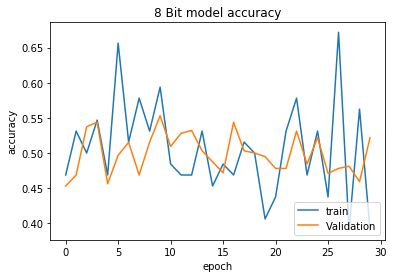

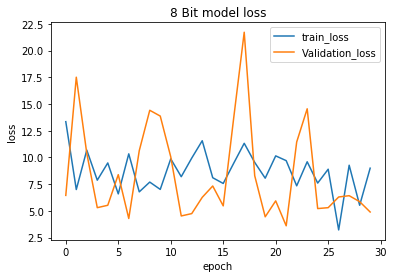

In [9]:
#Graph represenattaion of loss and accuracy
plt.figure()
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])
plt.title('8 Bit model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='lower right')
plt.figure()
print(f"Training maximum accuracy: {np.max(hist.history['acc']) * 100:.2f} %")
print(f"Validation maximum accuracy: {np.max(hist.history['val_acc']) * 100:.2f} %")
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('8 Bit model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'Validation_loss'], loc='upper right')

print(f"Training model minimum loss: {np.min(hist.history['loss'])}")
print(f"Validation model minimum loss : {np.min(hist.history['val_loss']) }")
